In [1]:
import anndata
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import loompy
from Bio import Phylo
import scanpy as sc
import phylovelo as pv


from matplotlib import font_manager
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
import re

In [4]:
data_path = '/data3/wangkun/phylovelo_datasets/quinn/'

In [5]:
lg = 2

tree_file = data_path + f'tree/m5k_lg{lg}_tree_nj.processed_pruned.txt'
phylo_tree = Phylo.read(tree_file, 'newick')

In [7]:
ldata = scv.read(data_path + "Quinn2021_merged.loom", cache=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
ldata.obs.index = [re.sub(':', '.', i) for i in ldata.obs.index]
lgs = pd.read_csv(data_path + 'M5k_cellBC_LineageGroup.txt', sep='\t', header=None)

In [9]:
ldata1 = ldata[np.isin(ldata.obs.index, lgs.loc[lgs[1]==lg][0])]
sel_cells = ldata.obs.index[np.isin(ldata.obs.index, [i.name for i in phylo_tree.get_terminals()])]
ldata1 = ldata1[sel_cells]
ldata1.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
sc.tl.score_genes_cell_cycle(ldata1, s_genes=s_genes, g2m_genes=g2m_genes)

In [11]:
cycling = (ldata1.obs['G2M_score']>=0.2) | (ldata1.obs['S_score']>0.2)
non_cycling = (ldata1.obs['G2M_score']<0) & (ldata1.obs['S_score']<0)
intermediate = ~(cycling | non_cycling)
ldata1 = ldata1[non_cycling]

Trying to set attribute `.obs` of view, copying.


Filtered out 31087 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:15) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/160 cores)


  0%|          | 0/379 [00:00<?, ?gene/s]

    finished (0:02:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/1616 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


<AxesSubplot: title={'center': 'Clusters'}>

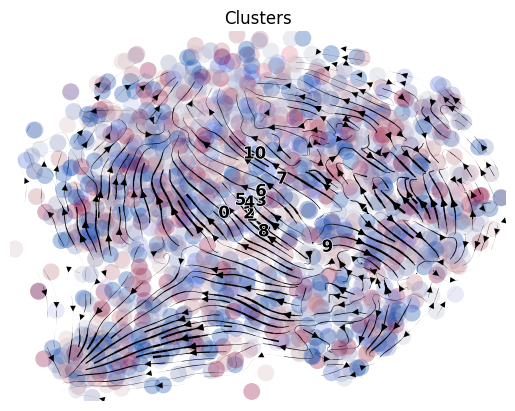

In [12]:
scv.pp.filter_and_normalize(ldata1, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ldata1, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(ldata1, n_jobs=1)
scv.tl.velocity(ldata1, mode="dynamical")
scv.tl.velocity_graph(ldata1)
scv.tl.tsne(ldata1,random_state=2)
scv.pl.velocity_embedding_stream(ldata1, basis='tsne',color=['Clusters'], show=False)

In [13]:
scv.tl.latent_time(ldata1)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [14]:
ldata2 = ldata[np.isin(ldata.obs.index, lgs.loc[lgs[1]==lg][0])]
sel_cells = ldata.obs.index[np.isin(ldata.obs.index, [i.name for i in phylo_tree.get_terminals()])]
ldata2= ldata2[sel_cells]
ldata2 = ldata2[non_cycling]
ldata2.var_names_make_unique()

sd = pv.scData(count=ldata2.X.A, cell_names=list(ldata2.obs.index))
sd.count = pd.DataFrame(data=sd.count, index=sd.cell_names, columns=ldata2.var.index)
sd.phylo_tree = phylo_tree
sd.Xdr = pd.DataFrame(data=ldata1.obsm['X_tsne'], index=sd.cell_names)
sd.cell_states = [int(i) for i in ldata2.obs.Clusters]
scv.pp.filter_and_normalize(ldata2, min_shared_counts=20)
sd.x_normed = pd.DataFrame(data=ldata2.X.A, index=ldata2.obs_names, columns=ldata2.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 31087 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [15]:
tree_depths = sd.phylo_tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [depths_map[i] for i in sd.count.index]

In [16]:
pv.velocity_inference(sd, depths, target='x_normed')
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/5514 [00:00<?, ?it/s]

  0%|          | 0/1616 [00:00<?, ?it/s]

In [17]:
pv.calc_phylo_pseudotime(sd, 30, 0.2)

  0%|          | 0/322 [00:00<?, ?it/s]

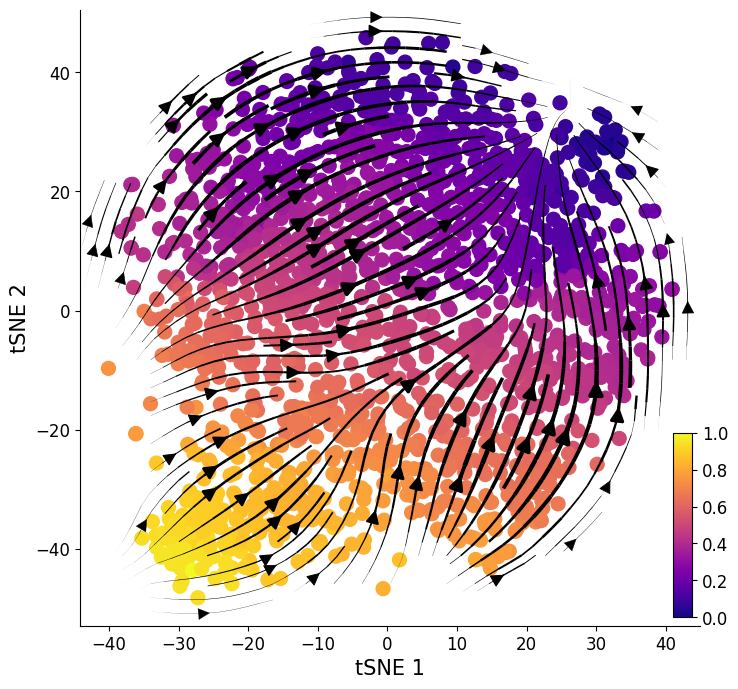

In [18]:
fig, ax = plt.subplots()
scatter=ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream', radius=5, lw_coef=1000, arrowsize=2)
ax.figure.set_size_inches(8, 8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('./figures/fig6/A549_stream.pdf')

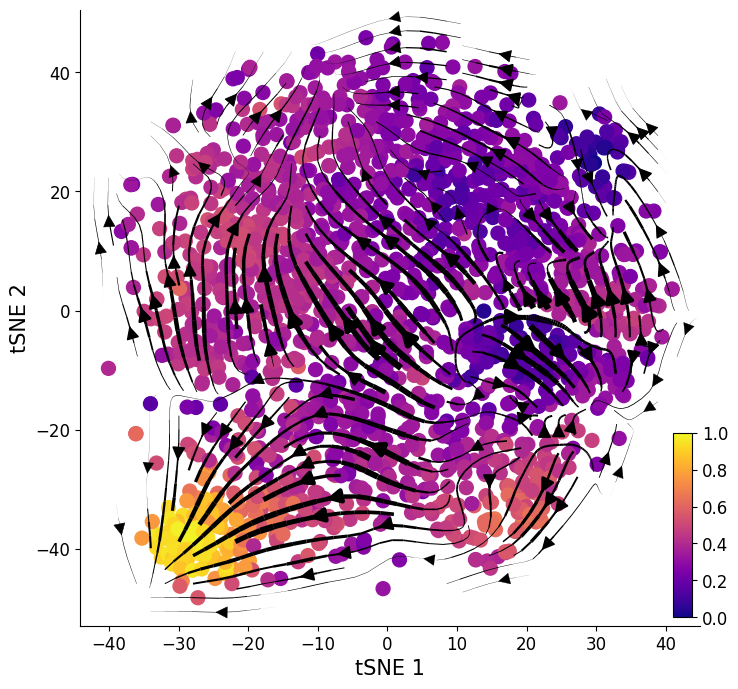

In [19]:
fig, ax = plt.subplots()
scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=ldata1.obs['latent_time'],cmap='plasma')
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), ldata1.obsm['velocity_tsne'], ax, 'stream', streamdensity=1.5, radius=5, lw_coef=3, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [33]:
import numpy as np
from scipy.stats import pearsonr

def corr_plot(x, y, ax):

    a, b = np.polyfit(x, y, deg=1)
    y_est = a * np.linspace(min(x),max(x),60) + b

    # fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(x, y, alpha=0.4, s=70)
    ax.plot(np.linspace(min(x),max(x),60), y_est, '-', c='k')
    # ax.set_xlabel('Velocity Embryo2')
    # ax.set_ylabel('Velocity Embryo3')
    r, pval = pearsonr(x, y)
    ax.text(min(x)*1, max(y), r"Pearson $r$={:.2g}".format(r), fontsize=10)
    try:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=10)
    except:
        ax.text(min(x)*1, max(y)-(max(y)-min(y))*0.1, r'$P={:.2f}$'.format(pval))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

Text(0.5, 0, 'G2M score')

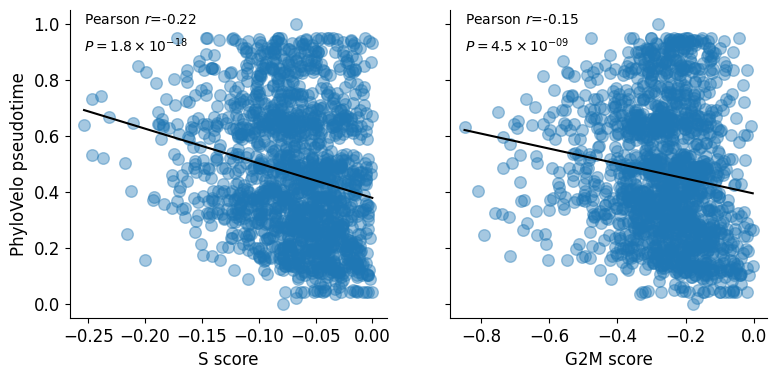

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
corr_plot(ldata1[sd.count.index].obs['S_score'], sd.phylo_pseudotime, ax[0])
corr_plot(ldata1[sd.count.index].obs['G2M_score'], sd.phylo_pseudotime, ax[1])
ax[0].set_ylabel('PhyloVelo pseudotime')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

Text(0.5, 0, 'G2M score')

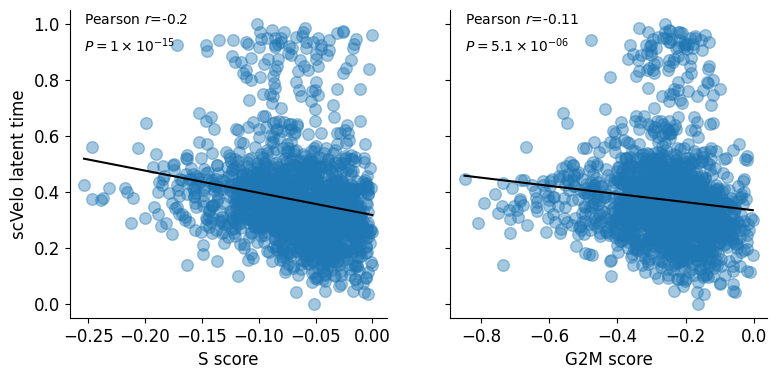

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
corr_plot(ldata1[sd.count.index].obs['S_score'], ldata1[sd.count.index].obs['latent_time'], ax[0])
corr_plot(ldata1[sd.count.index].obs['G2M_score'], ldata1[sd.count.index].obs['latent_time'], ax[1])
ax[0].set_ylabel('scVelo latent time')
ax[0].set_xlabel('S score')
ax[1].set_xlabel('G2M score')

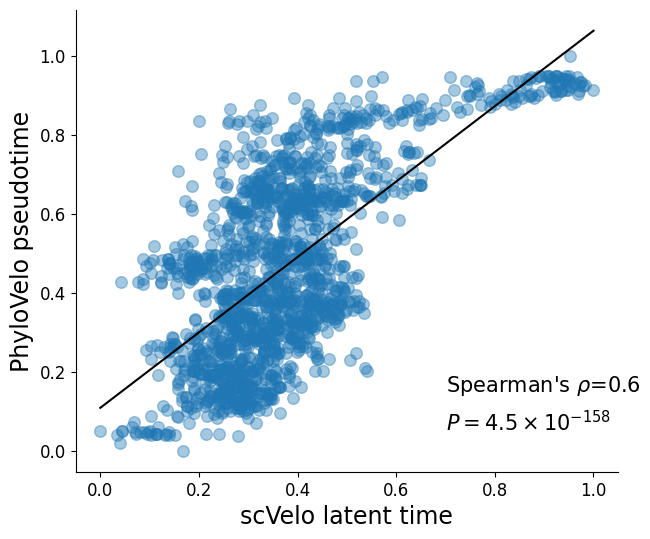

In [27]:
from scipy.stats import spearmanr
x = ldata1.obs['latent_time']
y = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(0,1,60) + b

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(x, y, alpha=0.4, s=70)
ax.plot(np.linspace(0,1,60), y_est, '-', c='k')
ax.set_xlabel('scVelo latent time', fontsize=17)
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
rho, pval = spearmanr(x, y)
ax.text(0.7, 0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(0.7, 0.05, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [28]:
import pickle
with open(f'/data3/wangkun/read_sd_file/a549_lg2_noncycling', 'wb') as f:
    pickle.dump(sd, f)

In [33]:
# cyt = pd.read_csv('./lg1_cytotrace.csv', index_col=0)
# cyt = cyt.loc[sd.count.index]
# fig, ax = plt.subplots()
# scatter = ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], s=100, c=cyt['x'], alpha=0.2)

In [36]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/a549-lg2_nc.csv')

In [38]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(depths)
pv.velocity_inference(sd_shuffle, depths, target='x_normed')

v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/a549-lg2_nc_shuffle.csv')

  0%|          | 0/5514 [00:00<?, ?it/s]

In [33]:
lg1_megs = pd.read_csv('./megs/a549-lg1.csv', index_col=0)
lg2_megs = pd.read_csv('./megs/a549-lg2.csv', index_col=0)

In [34]:
common = list(set(lg1_megs.index).intersection(lg2_megs.index))

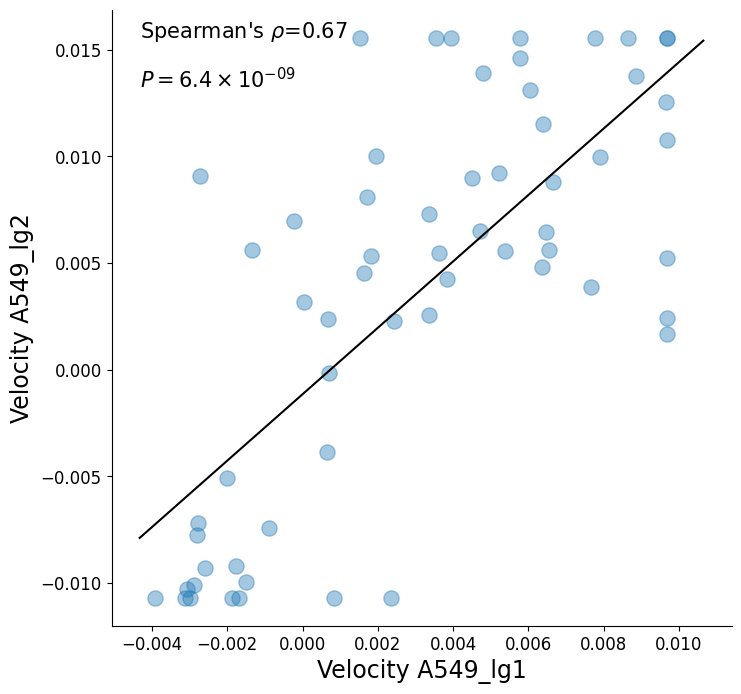

In [37]:
# plt.scatter(lg1_megs.loc[common]['v'], lg2_megs.loc[common]['v'])

x = lg1_megs.loc[common]['velocity']
y = lg2_megs.loc[common]['velocity']

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x)*1.1, max(x)*1.1, 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x)*1.1, max(x)*1.1, 60), y_est, '-', c='k')
ax.set_xlabel('Velocity A549_lg1', fontsize=17)
ax.set_ylabel('Velocity A549_lg2', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(min(x)*1.1, max(y)*0.85, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [34]:
from scipy.stats import spearmanr
# spearmanr(lg1_megs.loc[common]['v'], lg2_megs.loc[common]['v'])

In [52]:
markers_EMT= ["ACVR1", "AGER", "ALX1", "AXIN2", "BAMBI", "BCL9L", "BMP2", "BMP4", "BMP7", "COL1A1", "CRB2", "CTNNB1", "DAB2", "ENG", "EZH2", "FOXC1", "GCNT2", "GLIPR2", "HDAC2", "IL1B", "IL6", "ISL1", "JAG1", "LEF1", "LOXL2", "MDK", "MTOR", "MYOCD", "NOTCH1", "PDPN", "RGCC", "SDCBP", "SERPINB3D", "SMAD2", "SMAD3", "SMAD4", "SNAI1", "TCF7L2", "TGFB1", "TGFB1I1", "TGFB2", "TGFB3", "TGFBR1", "TGFBR2", "TWIST1", "WWTR1", "ZFP703"]

In [53]:
emt_score = sd.x_normed.iloc[:,np.isin(sd.x_normed.columns, markers_EMT)].mean(1)

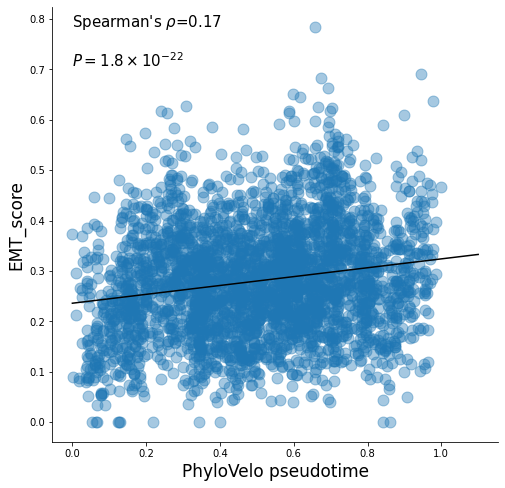

In [37]:
y = emt_score
x = sd.phylo_pseudotime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x)*1.1, max(x)*1.1, 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x)*1.1, max(x)*1.1, 60), y_est, '-', c='k')
ax.set_ylabel('EMT_score', fontsize=17)
ax.set_xlabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

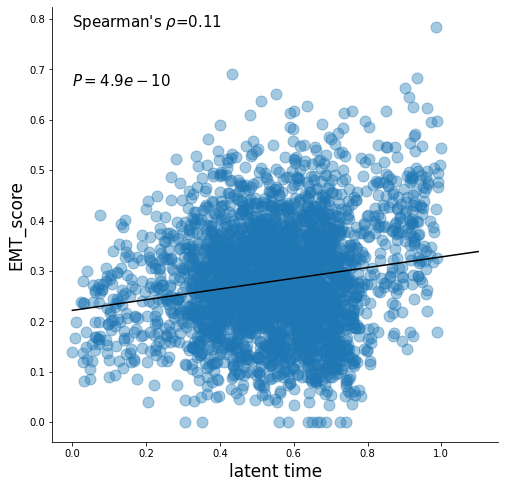

In [38]:
y = emt_score
x = ldata1.obs['latent_time']

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x)*1.1, max(x)*1.1, 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x)*1.1, max(x)*1.1, 60), y_est, '-', c='k')
ax.set_ylabel('EMT_score', fontsize=17)
ax.set_xlabel('latent time', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, max(y)*0.85, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
ax.text(min(x)*1.1, max(y)*0.85, r'$P={:.2g}$'.format(pval), fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [40]:
from copy import deepcopy

In [41]:
lg1_latenttime = deepcopy(ldata1.obs['latent_time'].to_numpy())
lg1_pvpt = deepcopy(sd.phylo_pseudotime)
lg1_emtscore = emt_score

In [54]:
lg2_latenttime = deepcopy(ldata1.obs['latent_time'].to_numpy())
lg2_pvpt = deepcopy(sd.phylo_pseudotime)
lg2_emtscore = emt_score

In [55]:
latenttime = np.concatenate((lg1_latenttime, lg2_latenttime))
pvpt = np.concatenate((lg1_pvpt, lg2_pvpt))
emtscore = np.concatenate((lg1_emtscore, lg2_emtscore))

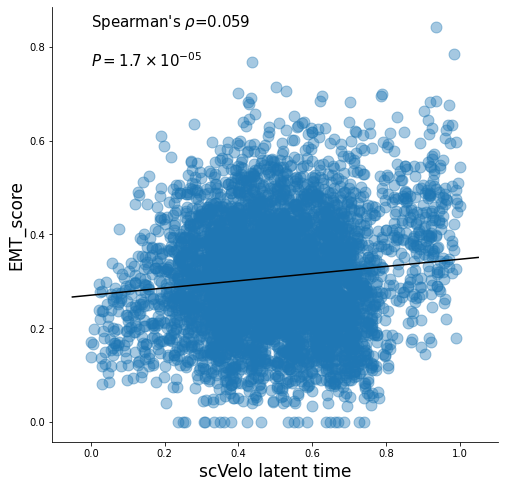

In [56]:
y = emtscore
x = latenttime

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x)*1.1, max(x)*1.1, 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x)-0.05, max(x)*1.05, 60), y_est, '-', c='k')
ax.set_ylabel('EMT_score', fontsize=17)
ax.set_xlabel('scVelo latent time', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
# ax.text(1.2, 0.02, r'$P={:.2g}$'.format(pval), fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

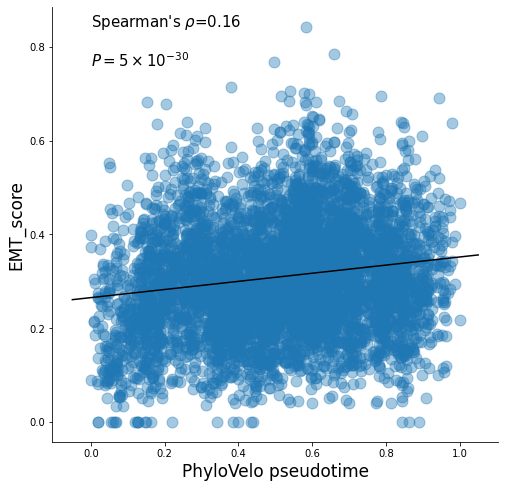

In [57]:
y = emtscore
x = pvpt

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x)*1.1, max(x)*1.1, 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x)-0.05, max(x)*1.05, 60), y_est, '-', c='k')
ax.set_ylabel('EMT_score', fontsize=17)
ax.set_xlabel('PhyloVelo pseudotime', fontsize=17)
# ax.text(0, 0.9, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)
ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
# ax.text(1.2, 0.02, r'$P={:.2g}$'.format(pval), fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [87]:
ctscore = pd.read_csv('./lg2_cytotrace.csv', index_col=0)
ctscore = ctscore.loc[sd.count.index]

In [30]:
from scipy.stats import spearmanr

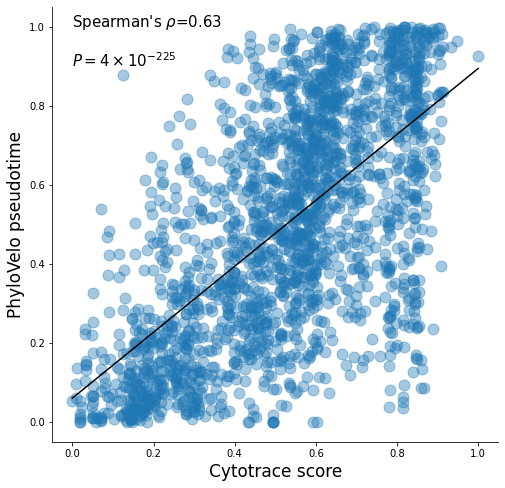

In [31]:
# plt.scatter(sd.phylo_pseudotime, sd.count.sum(axis=1))
x = sd.phylo_pseudotime
# y = np.array(adata_raw[sd.x_normed.index].X.sum(axis=1)).flatten()
y = ctscore['x']

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, alpha=0.4, s=120)
ax.plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
ax.set_ylabel('PhyloVelo pseudotime', fontsize=17)
ax.set_xlabel('Cytotrace score', fontsize=17)
# ax.set_title('kp3435 normalize', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.95, r"Spearman's $\rho$={:.2g}\n$P$={:.2g}".format(*spearmanr(x, y)), fontsize=15) 
rho, pval = spearmanr(x, y)

ax.text(min(x)*1.1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
if pval:
    ax.text(min(x)*1.1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)
else:
    ax.text(min(x)*1.1, max(y)*0.9, r'$P<10^{-100}$', fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [81]:
from scipy.stats import spearmanr
megs = pd.read_csv('quinn_lg2_megs.csv')

Text(0.04, 0.5, 'Total normalized UMI of MEGs')

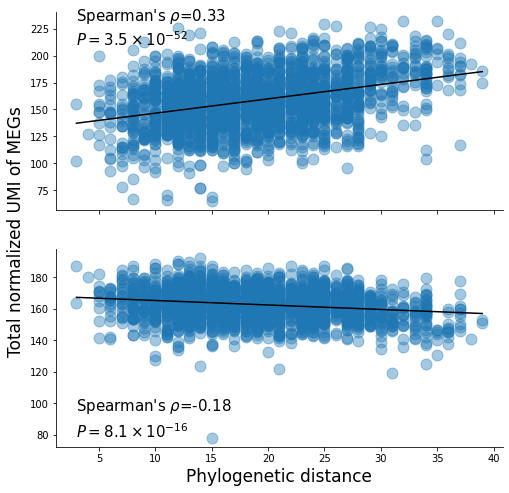

In [86]:
genes1 = megs['MEGs'][megs['v']>0].to_numpy()
genes2 = megs['MEGs'][megs['v']<0].to_numpy()

x = depths
y = sd.x_normed[genes1].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b

fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax[0].scatter(x, y, alpha=0.4, s=120)
ax[0].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[0].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
# ax[0].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[0].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[0].text(min(x)*1, max(y)*0.9, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

# ax.text(min(x)*1.1, min(y)*1.05, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
# ax.text(min(x)*1.1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)


x = depths
y = sd.x_normed[genes2].sum(axis=1)

a, b = np.polyfit(x, y, deg=1)
y_est = a * np.linspace(min(x), max(x), 60) + b


ax[1].scatter(x, y, alpha=0.4, s=120)
ax[1].plot(np.linspace(min(x), max(x), 60), y_est, '-', c='k')
# ax[1].set_ylabel('Total normalized UMI of MEGs', fontsize=17)
ax[1].set_xlabel('Phylogenetic distance', fontsize=17)
# ax.text(min(x)*1.1, max(y)*0.85, 'spearmanr={:.2g}\np_val={:.2g}'.format(*spearmanr(x, y)), fontsize=15)
rho, pval = spearmanr(x, y)

ax[1].text(min(x)*1, min(y)+(max(y)-min(y))*0.15, r"Spearman's $\rho$={:.2g}".format(rho), fontsize=15)
ax[1].text(min(x)*1, min(y)*1, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=15)

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

fig.text(0.04, 0.5, 'Total normalized UMI of MEGs', va='center', rotation='vertical',fontsize=17)

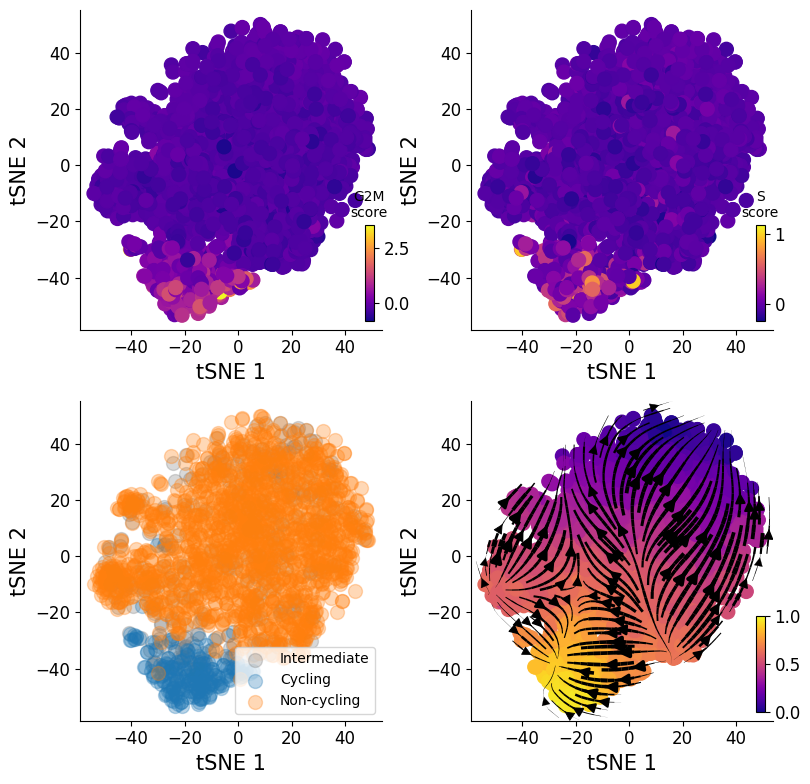

In [40]:
import scanpy as sc
import anndata as ad
adata = ad.AnnData(sd.count)
s_genes = ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2','USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']
g2m_genes= ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA']
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
fig, ax = plt.subplots(2, 2, figsize=(8,8))

scatter=ax[0][0].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=adata.obs['G2M_score'],cmap='plasma')
ax[0][0].set_xlabel('tSNE 1', fontsize=15)
ax[0][0].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[0][0], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0][0].spines['right'].set_visible(False)
ax[0][0].spines['top'].set_visible(False)
plt.title('G2M\nscore', fontsize=10)


scatter=ax[0][1].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=adata.obs['S_score'],cmap='plasma')
ax[0][1].set_xlabel('tSNE 1', fontsize=15)
ax[0][1].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[0][1], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0][1].spines['right'].set_visible(False)
ax[0][1].spines['top'].set_visible(False)
plt.title('S\nscore', fontsize=10)

cycling = (adata.obs['G2M_score']>=0.2) | (adata.obs['S_score']>0.2)
non_cycling = (adata.obs['G2M_score']<0) & (adata.obs['S_score']<0)
intermediate = ~(cycling | non_cycling)

ax[1][0].scatter(sd.Xdr.to_numpy()[intermediate, 0], sd.Xdr.to_numpy()[intermediate, 1], s=100, label='Intermediate',c='grey', alpha=0.3)
ax[1][0].scatter(sd.Xdr.to_numpy()[cycling, 0], sd.Xdr.to_numpy()[cycling, 1], s=100, label='Cycling', alpha=0.3)
ax[1][0].scatter(sd.Xdr.to_numpy()[non_cycling, 0], sd.Xdr.to_numpy()[non_cycling, 1], s=100, label='Non-cycling', alpha=0.3)


# ax = pv.velocity_plot(sd.Xdr.to_numpy(), adata.obsm['velocity_tsne'], ax, 'stream', grid_density=25, radius=5, lw_coef=4, arrowsize=1.5)
ax[1][0].set_xlabel('tSNE 1', fontsize=15)
ax[1][0].set_ylabel('tSNE 2', fontsize=15)
ax[1][0].legend(fontsize=10)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[1][0].spines['right'].set_visible(False)
ax[1][0].spines['top'].set_visible(False)

# ax[0][0].set_xlim(-50, 60)
# ax[0][1].set_xlim(-50, 60)
# ax[1][0].set_xlim(-50, 60)

# ax[1][1].set_visible(False)

# fig, ax = plt.subplots(figsize=(8,8))
scatter = ax[1][1].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], s=100, c=sd.phylo_pseudotime,cmap='plasma')
ax[1][1] = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[1][1], 'stream', grid_density=25, radius=5, lw_coef=1000, arrowsize=1.5)
ax[1][1].set_xlabel('tSNE 1', fontsize=15)
ax[1][1].set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax[1][1], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[1][1].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)

plt.tight_layout()